<a href="https://colab.research.google.com/github/sajad95/Heat/blob/main/FastCodeImpactofweatherXGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Let's do it :)

# installing librarires
!pip install scikit-learn --upgrade --quiet
!pip install pandas --quiet
!pip install xgboost


# importing libraries
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score


# mounting google drive and uploading the data
drive.mount('/content/saj')
raw_df = pd.read_csv('/content/saj/MyDrive/Kavgic/AllFeaturesInAllyears2.csv')
TMY_df = pd.read_csv('/content/saj/MyDrive/Kavgic/TW.csv')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/saj


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##Impact of weather data on energy demand


Goal is to find the best ways for predicting energy demand in 2019 and compare it with the doe model.

 scenarios:
1.   **Training the model with data from 2011 to 2017**

*   predicting energy demand for 2019 when the TW is used ( used both TW files) and comapre it with 2018.  if I want to predict energy demand of 2019 wihout having any data, is it better to use TW or use weather data for previous years. If I want to use data belonged to previous years which year can prdict it better.
*   Effect of number of years on accuracy
*   Finding the accuarcy of model in max and min
*   See the accuaracy of the model on design days



2.   **Improving the accuracy of the model in mins and maxes**

*   Training the Heating and Cooling with deata belonged to cold and warm days
*   Training the data with two TW files
*   Testing the Data of a hot place for cooling
*   Removing columns maybe removin some columns decrease the r2 but it might increase the robutensess of model in predicting min and max
*   Effect of energy unit on result of prediction j vs kj vs Mj 












##1 predicting energy demand for 2019


* Goal is to find the accuary of he model:  R2 between ( predicted by data of 2019, Real data 2019)
* How well TW can predict 2019 R2 between( TW, Real data 2019 )
* How well TW can predict 2018 R2 between( 2018, Real data 2019 )



In [ ]:
############# Light Electricity (j) ############# 
#electricity
raw_df1=raw_df.drop(raw_df.columns[[1,35,36,37,38]], axis=1)

## Typical weather data file ( all parts of energy consumption)
#electricity
TMY_df1=TMY_df.drop(TMY_df.columns[[1,35,36,37,38]], axis=1)

##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df1.Date).dt.year

train_df = raw_df1[year < 2017]
val_df = raw_df1[year == 2017]
test_df = raw_df1[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'LightsElectricity'
## specifying input an target in Typical weather data file
input_cols_TMY1 = (TMY_df1.columns)[1:-1]
target_col_TMY1 = 'LightsElectricity'

## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df1[input_cols_TMY1].copy()
test_targets_TMY = TMY_df1[target_col_TMY1].copy()

# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data

model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

[12:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
A =pd.DataFrame(test_df[target_col]) 

A.reset_index(inplace = True)
A.drop('index', axis=1, inplace=True)
A

,LightsElectricity
0,396147.8
1,396147.8
2,396147.8
3,396147.8
4,396147.8
...,...
8755,396147.8
8756,396147.8
8757,396147.8
8758,396147.8


In [ ]:
LightsElectricity = pd.DataFrame(preds4, columns =['predicted for LightsElectricity2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
LightsElectricity[' LightsElectricity Real Values'] = A 
raw_df.to_csv('LightsElectricity.csv')
LightsElectricity

,predicted for LightsElectricity2019 using TMY,LightsElectricity Real Values
0,396916.71875,396147.8
1,396044.37500,396147.8
2,392235.03125,396147.8
3,401619.78125,396147.8
4,401619.78125,396147.8
...,...,...
8755,408548.75000,396147.8
8756,405176.93750,396147.8
8757,405176.93750,396147.8
8758,408548.75000,396147.8


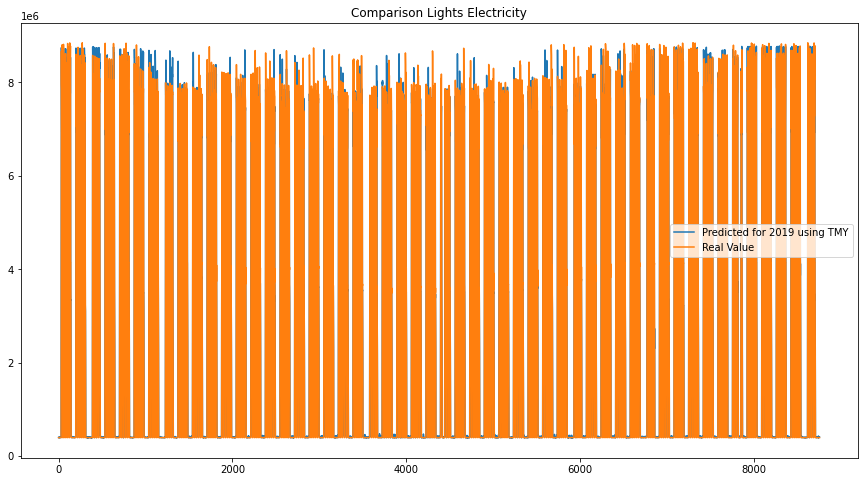

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="Predicted for 2019 using TMY")
#plt.plot(x_ax,preds3, label = "Predicted for 2019 using data of 2019")
plt.plot(x_ax,A, label = "Real Value ")
plt.title("Comparison Lights Electricity")
plt.legend()
plt.show()


In [ ]:
############# Defining Scenarios ############# 
## Actua weather data file (all parts of energy consumption)

#cooling : [[34,36,37,38]]
raw_df2=raw_df.drop(raw_df.columns[[1,34,36,37,38]], axis=1)

#cooling : [[34,36,37,38]]
TMY_df2=TMY_df.drop(TMY_df.columns[[1,34,36,37,38]], axis=1)


##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df2.Date).dt.year

train_df = raw_df2[year < 2017]
val_df = raw_df2[year == 2017]
test_df = raw_df2[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'Cooling'
## specifying input an target in Typical weather data file
input_cols_TMY2 = (TMY_df2.columns)[1:-1]
target_col_TMY2 = 'Cooling'


## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df2[input_cols_TMY2].copy()
test_targets_TMY = TMY_df2[target_col_TMY2].copy()



# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data
model.fit(train_inputs, train_targets)
preds = model.predict(train_inputs)


model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

[13:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
B=pd.DataFrame(test_df[target_col]) 

B.reset_index(inplace = True)
B.drop('index', axis=1, inplace=True)
B

,Cooling
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8755,0.0
8756,0.0
8757,0.0
8758,0.0


In [ ]:
cooling = pd.DataFrame(preds4, columns =['predicted for cooling 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
cooling[' cooling Real Values'] = B 
raw_df.to_csv('cooling.csv')
cooling

,predicted for cooling 2019 using TMY,cooling Real Values
0,-41.846771,0.0
1,-41.846771,0.0
2,-1265.347778,0.0
3,-1265.347778,0.0
4,-1265.347778,0.0
...,...,...
8755,-1265.347778,0.0
8756,-1265.347778,0.0
8757,-1265.347778,0.0
8758,-1265.347778,0.0


In [ ]:
#cooling = pd.DataFrame(preds3, columns =['coolingvia2019 '])
#cooling['cooling via TMY'] = pd.DataFrame(preds4)
#cooling[' cooling Real Values'] = B
#raw_df.to_csv('cooling.csv')
#cooling

In [ ]:
#coolingvia2019 = pd.DataFrame(preds3, columns =['energy via 2019'])
#coolingvia2019['energy via TMY'] = pd.DataFrame(preds4)

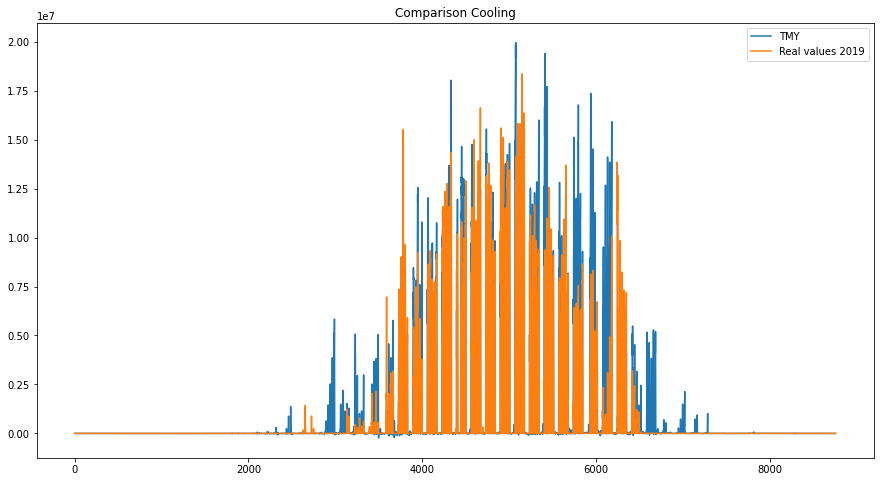

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,B, label = "Real values 2019")
plt.title("Comparison Cooling")
plt.legend()
plt.show()

In [ ]:
############# Defining Scenarios ############# 
## Actua weather data file (all parts of energy consumption)

#Heating : [[34,35,37,38]]
raw_df3=raw_df.drop(raw_df.columns[[1,34,35,37,38]], axis=1)


## Typical weather data file ( all parts of energy consumption)

#Heating : [[34,35,37,38]]
TMY_df3=TMY_df.drop(TMY_df.columns[[1,34,35,37,38]], axis=1)


##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df3.Date).dt.year

train_df = raw_df3[year < 2017]
val_df = raw_df3[year == 2017]
test_df = raw_df3[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'Heating'
## specifying input an target in Typical weather data file
input_cols_TMY2 = (TMY_df3.columns)[1:-1]
target_col_TMY2 = 'Heating'


## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df3[input_cols_TMY2].copy()
test_targets_TMY = TMY_df3[target_col_TMY2].copy()



# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data
model.fit(train_inputs, train_targets)
preds = model.predict(train_inputs)


model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

[13:53:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
C=pd.DataFrame(test_df[target_col]) 

C.reset_index(inplace = True)
C.drop('index', axis=1, inplace=True)
C

,Heating
0,900000.0
1,900000.0
2,900000.0
3,900000.0
4,900000.0
...,...
8755,11735676.0
8756,12807904.0
8757,11698992.0
8758,12792717.0


In [ ]:
Heating = pd.DataFrame(preds4, columns =['predicted for Heating 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

,predicted for Heating 2019 using TMY,Heating Real Values
0,9.746604e+06,900000.0
1,1.098262e+07,900000.0
2,1.192441e+07,900000.0
3,1.217588e+07,900000.0
4,1.250906e+07,900000.0
...,...,...
8755,8.669098e+05,11735676.0
8756,8.629210e+05,12807904.0
8757,8.669098e+05,11698992.0
8758,8.629210e+05,12792717.0


In [ ]:
#Heating = pd.DataFrame(preds3, columns =['Heating 2019 '])
#Heating['Heating via TMY'] = pd.DataFrame(preds4)
#Heating.to_csv('Heating.csv')
#Heating

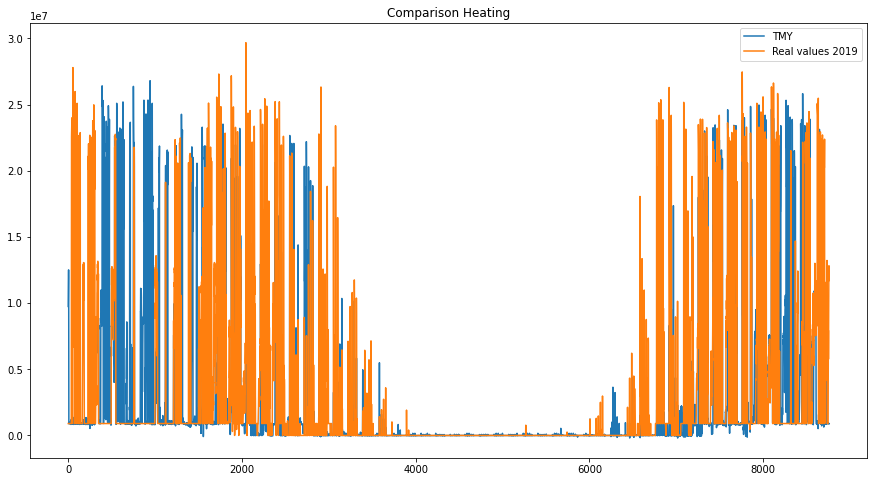

In [ ]:
plt.figure(figsize=(15,8));

x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
TMY_df3['Heating'][246]

900000.0

In [ ]:
TMY_df3.loc[108:113]

In [ ]:
from IPython.display import display
with pd.option_context('display.max_rows', 50):
    display(TMY_df3[TMY_df3.Heating > 1000]);

In [ ]:
new_input = {'Dry Bulb Temperature': -24.5,
             'Dew Point Temperature': -28.4,
             'Relative Humidity': 70,
             'Atmospheric Pressure': 100480,
             'Extraterrestrial Horizontal Radiation': 0,
             'Extraterrestrial Direct Normal Radiation': 9999,
             'Horizontal Infrared Radiation Intensity from Sky': 166,
             'Global Horizontal Radiation': 0,
             'Direct Normal Radiation': 0,
             'Diffuse Horizontal Radiation': 0,
             'Global Horizontal Illuminance': 0,
             'Direct Normal Illuminance': 0,
             'Diffuse Horizontal Illuminance':0,
             'Zenith Luminance': 9999,
             'Wind Direction': 20,
             'Wind Speed': 6,
             'Total Sky Cover': 0,
             'Opaque Sky Cover': 8,
             'Visibility': 999,
             'Ceiling Height': 99990,
             'Present Weather Observation':9,
             'Precipitable Water': 0,
             'Aerosol Optical Depth':0 ,
             'Snow Depth' : 0,
             'Days Since Last Snow': 88,
             'Albedo' : 999,
             'Liquid Precipitation Depth' :999 ,
             'Liquid Precipitation Quantity' : 99,
             'People Total Heating Energy' :0 ,
             'Total Zone Infiltration Sensible Heat Gain Energy' : 893710,
             'Averge Zones temp': 14.66877,
             'ATTIC:Zone Air Temperature' : -24,
             
              }

In [ ]:
new_input_df = pd.DataFrame([new_input])
new_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Dry Bulb Temperature                               1 non-null      float64
 1   Dew Point Temperature                              1 non-null      float64
 2   Relative Humidity                                  1 non-null      int64  
 3   Atmospheric Pressure                               1 non-null      int64  
 4   Extraterrestrial Horizontal Radiation              1 non-null      int64  
 5   Extraterrestrial Direct Normal Radiation           1 non-null      int64  
 6   Horizontal Infrared Radiation Intensity from Sky   1 non-null      int64  
 7   Global Horizontal Radiation                        1 non-null      int64  
 8   Direct Normal Radiation                            1 non-null      int64  
 9   Diffuse Horizo

In [ ]:
prediction = model.predict(new_input_df)
prediction

array([764330.5], dtype=float32)